In [1]:
import os, sys, warnings, time, memory_profiler
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from nn import NNClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'ffnn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)

Training set size: 841
Validation set size: 259
Test set size: 195


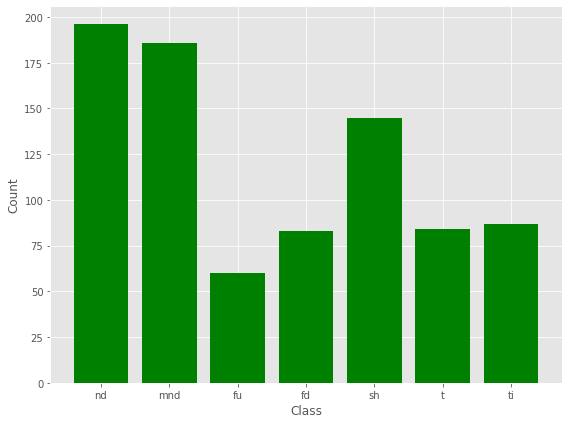

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

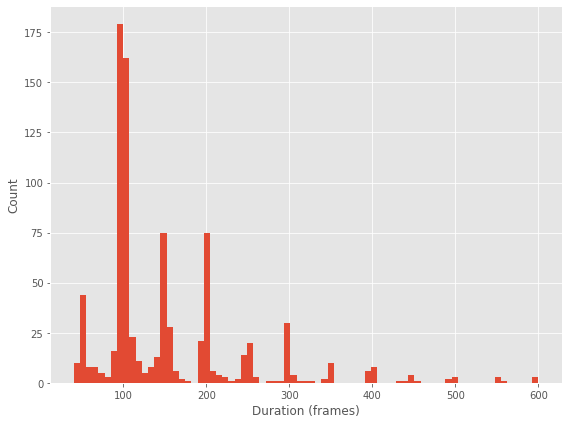

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

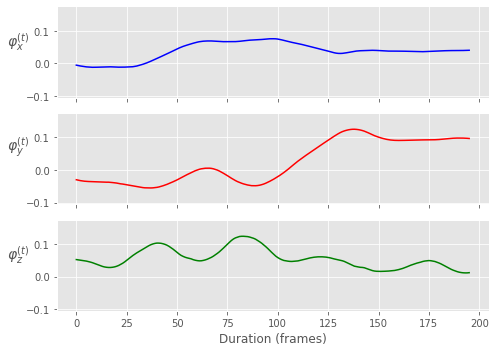

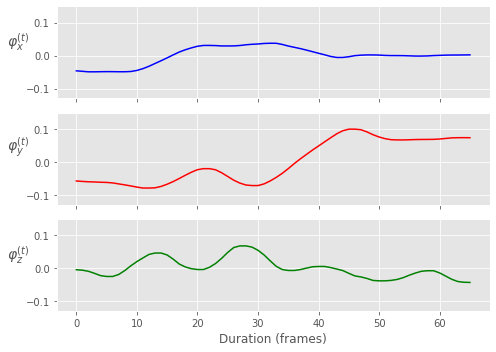

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1]
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

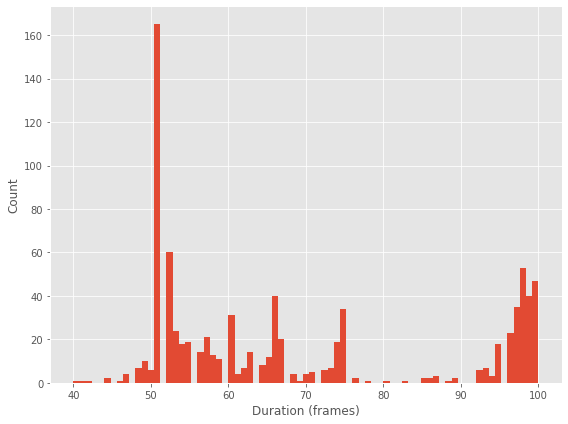

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

### Evaluating the model

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

### Evaluating the model

## Feedforward Neural Network classifier

### Fitting the model

### Evaluating the model

## LSTM classifier

### Fitting the model

### Evaluating the model

# Final experiments

## HMM

## DTWKNN

### Radius parameter

### Neighborhood parameter ($k$)

## FFNN

In [14]:
for repeat in range(5):
    seed = repeat
    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)
    
    X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)
    Xp_train = pre.fit_transform(X_train, verbose=True)
    Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)
    
    for n_layers in (1, 2, 3, 4):
        for n_units in (100, 150, 200, 250, 300):
    
            clf = None
            running_stats = {'fit': {}, 'predict': {}}

            def fit():
                clf = NNClassifier(epochs=75, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
                
                arch = []
                arch.append(Flatten())
                for _ in range(n_layers):
                    arch += [Dense(n_units, activation='relu'), Dropout(0.5)]
                arch.append(Dense(len(gestures), activation='softmax'))
                
                clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=False)
                return clf

            t0 = time.time()
            mem, clf = memory_profiler.memory_usage(fit, retval=True)
            running_stats['fit']['memory'] = max(mem)
            running_stats['fit']['time'] = time.time() - t0

            def evaluate():
                return clf.evaluate(Xp_val, y_val)

            t0 = time.time()
            mem, res = memory_profiler.memory_usage(evaluate, retval=True, include_children=True)
            running_stats['predict']['memory'] = max(mem)
            running_stats['predict']['time'] = time.time() - t0
            results['ffnn']['validation'] = res

            # Write the results
            write_network_results('ffnn', results, running_stats, '{}layers {}units'.format(n_layers, n_units), 'validation', number=repeat, save_cm=True)

Training set size: 841
Validation set size: 259
Test set size: 195



Train on 841 samples, validate on 259 samples
Epoch 1/75
841/841 [==============================] - 2s 3ms/sample - loss: 1.9366 - accuracy: 0.1593 - val_loss: 1.8898 - val_accuracy: 0.3398
Epoch 2/75
841/841 [==============================] - 0s 33us/sample - loss: 1.8777 - accuracy: 0.3246 - val_loss: 1.8432 - val_accuracy: 0.3977
Epoch 3/75
841/841 [==============================] - 0s 32us/sample - loss: 1.8285 - accuracy: 0.3484 - val_loss: 1.8009 - val_accuracy: 0.4054
Epoch 4/75
841/841 [==============================] - 0s 33us/sample - loss: 1.7823 - accuracy: 0.4007 - val_loss: 1.7594 - val_accuracy: 0.4015
Epoch 5/75
841/841 [==============================] - 0s 32us/sample - loss: 1.7470 - accuracy: 0.3817 - val_loss: 1.7229 - val_accuracy: 0.3977
Epoch 6/75
841/841 [==============================] - 0s 32us/sample - loss: 1.7137 - accuracy: 0.3805 - val_loss: 1.6916 - val_accuracy: 0.3784
Epoch 7/75
841/841 [==============================] - 0s 33us/sample - loss: 1.6776 


Train on 841 samples, validate on 259 samples
Epoch 1/75
841/841 [==============================] - 1s 621us/sample - loss: 1.9302 - accuracy: 0.2128 - val_loss: 1.8987 - val_accuracy: 0.3089
Epoch 2/75
841/841 [==============================] - 0s 44us/sample - loss: 1.8610 - accuracy: 0.3008 - val_loss: 1.8554 - val_accuracy: 0.3205
Epoch 3/75
841/841 [==============================] - 0s 43us/sample - loss: 1.8138 - accuracy: 0.3424 - val_loss: 1.8192 - val_accuracy: 0.3050
Epoch 4/75
841/841 [==============================] - 0s 40us/sample - loss: 1.7672 - accuracy: 0.3555 - val_loss: 1.7882 - val_accuracy: 0.3127
Epoch 5/75
841/841 [==============================] - 0s 38us/sample - loss: 1.7171 - accuracy: 0.3579 - val_loss: 1.7604 - val_accuracy: 0.3205
Epoch 6/75
841/841 [==============================] - 0s 36us/sample - loss: 1.6945 - accuracy: 0.3757 - val_loss: 1.7358 - val_accuracy: 0.3398
Epoch 7/75
841/841 [==============================] - 0s 36us/sample - loss: 1.649


Train on 841 samples, validate on 259 samples
Epoch 1/75
841/841 [==============================] - 1s 623us/sample - loss: 1.9306 - accuracy: 0.1950 - val_loss: 1.8844 - val_accuracy: 0.3089
Epoch 2/75
841/841 [==============================] - 0s 42us/sample - loss: 1.8692 - accuracy: 0.3008 - val_loss: 1.8383 - val_accuracy: 0.3089
Epoch 3/75
841/841 [==============================] - 0s 41us/sample - loss: 1.8248 - accuracy: 0.3210 - val_loss: 1.8008 - val_accuracy: 0.3282
Epoch 4/75
841/841 [==============================] - 0s 43us/sample - loss: 1.7835 - accuracy: 0.3413 - val_loss: 1.7702 - val_accuracy: 0.3475
Epoch 5/75
841/841 [==============================] - 0s 39us/sample - loss: 1.7450 - accuracy: 0.3341 - val_loss: 1.7399 - val_accuracy: 0.3591
Epoch 6/75
841/841 [==============================] - 0s 37us/sample - loss: 1.6972 - accuracy: 0.3603 - val_loss: 1.7142 - val_accuracy: 0.3629
Epoch 7/75
841/841 [==============================] - 0s 36us/sample - loss: 1.685


Train on 841 samples, validate on 259 samples
Epoch 1/75
841/841 [==============================] - 1s 643us/sample - loss: 1.9195 - accuracy: 0.2069 - val_loss: 1.8943 - val_accuracy: 0.2934
Epoch 2/75
841/841 [==============================] - 0s 44us/sample - loss: 1.8514 - accuracy: 0.3115 - val_loss: 1.8587 - val_accuracy: 0.2587
Epoch 3/75
841/841 [==============================] - 0s 40us/sample - loss: 1.8015 - accuracy: 0.3460 - val_loss: 1.8301 - val_accuracy: 0.2587
Epoch 4/75
841/841 [==============================] - 0s 39us/sample - loss: 1.7549 - accuracy: 0.3543 - val_loss: 1.8087 - val_accuracy: 0.2587
Epoch 5/75
841/841 [==============================] - 0s 41us/sample - loss: 1.7260 - accuracy: 0.3508 - val_loss: 1.7904 - val_accuracy: 0.2703
Epoch 6/75
841/841 [==============================] - 0s 36us/sample - loss: 1.6970 - accuracy: 0.3567 - val_loss: 1.7741 - val_accuracy: 0.2703
Epoch 7/75
841/841 [==============================] - 0s 36us/sample - loss: 1.664